In [26]:
import torch
import os
import cv2
import numpy as np
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Data augmentation and preprocessing for training
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Preprocessing for testing
transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
import matplotlib.pyplot as plt
train_dataset = ImageFolder(root=r'F:\works\A-important\A-neurals\ViT\asset\Data\train', transform=transform_train)
test_dataset = ImageFolder(root=r'F:\works\A-important\A-neurals\ViT\asset\Data\test', transform=transform_test)
# Utility function to plot images
# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
# def plot_images(data_loader, title="Dataset Visualization"):
#     """Plots all images from the given data loader."""
#     for i in range(7):
#         images, labels = next(iter(data_loader))
#         num_images = len(images)

#         fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
#         for i in range(num_images):
#             img = images[i].cpu().permute(1, 2, 0)
#             img = (img * 0.5 + 0.5).clamp(0, 1)  # Denormalize
#             axes[i].imshow(img)
#             axes[i].set_title(f"{labels[i].item()}")
#             axes[i].axis("off")
#         plt.suptitle(title)
#         plt.show()

# if __name__ == "__main__":
#     print("Visualizing Training Samples...")
#     plot_images(train_loader, title="Training Samples")

#     print("Visualizing Testing Samples...")
#     plot_images(test_loader, title="Testing Samples")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882353..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range

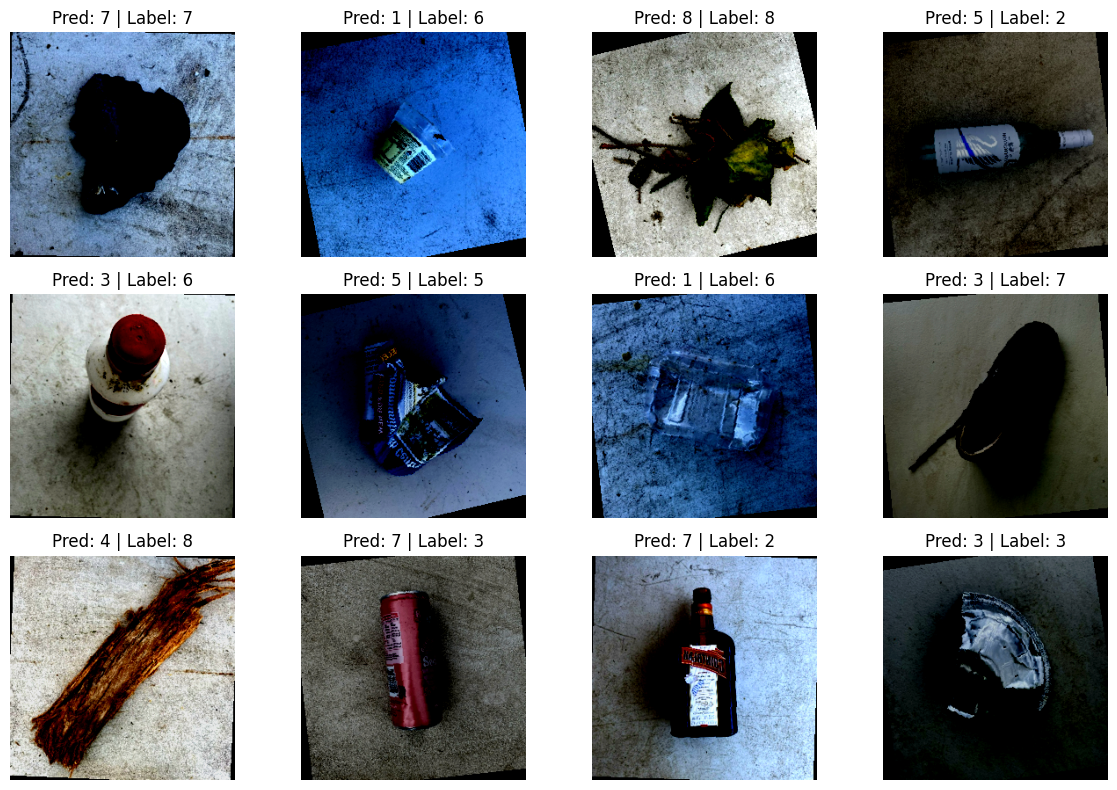

In [35]:
import torch
import torch.nn as nn
from model import ViT
# from DataProcessing import test_loader  # Assuming test_loader is imported directly from DataProcessing
import matplotlib.pyplot as plt

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT().to(device)
model.load_state_dict(torch.load(r"F:\works\A-important\A-neurals\ViT\checkpoints\afteroptim_model_epoch_30.pth"))
model.eval()

# Predict and visualize function
def predict_and_visualize(model, test_loader, device, num_images=12):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Visualization
    plt.figure(figsize=(12, 8))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 4, i + 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f'Pred: {predicted[i].item()} | Label: {labels[i].item()}')
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run the visualization
predict_and_visualize(model, train_loader, device)

In [23]:
import torch
import torch.nn as nn
import pandas as pd

def accuracy(output, original):
    return 100 - torch.mean(torch.abs(output - original) / original * 100)

data = pd.read_csv(r'F:\works\A-important\A-neurals\ViT\src\dataset.csv', header=None).values
X = torch.tensor(data[:, 1], dtype=torch.float32).view(-1, 1)
y = torch.tensor(data[:, 2], dtype=torch.float32).view(-1, 1)

X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

# Initialize Weights and Biases
W1, b1 = torch.randn(1, 32, requires_grad=True), torch.zeros(32, requires_grad=True)
W2, b2 = torch.randn(32, 16, requires_grad=True), torch.zeros(16, requires_grad=True)
W3, b3 = torch.randn(16, 1, requires_grad=True), torch.zeros(1, requires_grad=True)

lr = 0.01

for epoch in range(2000):
    # Forward pass
    h1 = torch.relu(X @ W1 + b1)
    h2 = torch.relu(h1 @ W2 + b2)
    prediction = h2 @ W3 + b3

    # Loss Calculation
    loss = accuracy(prediction, y)

    # Backward pass (manual gradient calculation)
    grad_output = torch.where(prediction > y, -100 / y, 100 / y)

    # Chain Rule - Backpropagating Gradients
    W3.grad = (h2.T @ grad_output) / X.size(0)
    b3.grad = (grad_output.mean(dim=0)).view_as(b3)

    grad_h2 = grad_output @ W3.T
    W2.grad = (h1.T @ (grad_h2 * (h2 > 0))) / X.size(0)
    b2.grad = (grad_h2 * (h2 > 0)).mean(dim=0).view_as(b2)

    grad_h1 = grad_h2 @ W2.T
    W1.grad = (X.T @ (grad_h1 * (h1 > 0))) / X.size(0)
    b1.grad = (grad_h1 * (h1 > 0)).mean(dim=0).view_as(b1)

    # Gradient Ascent
    with torch.no_grad():
        W1 += lr * W1.grad
        b1 += lr * b1.grad
        W2 += lr * W2.grad
        b2 += lr * b2.grad
        W3 += lr * W3.grad
        b3 += lr * b3.grad

        # Zero gradients
        W1.grad.zero_()
        b1.grad.zero_()
        W2.grad.zero_()
        b2.grad.zero_()
        W3.grad.zero_()
        b3.grad.zero_()

    if (epoch + 1) % 20 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

with torch.no_grad():
    X_test = torch.tensor([[5.0], [7.5], [10.0]])
    X_test = (X_test - X.mean()) / X.std()
    predictions = h2 @ W3 + b3
    print(predictions)


Epoch 20, Loss: nan
Epoch 40, Loss: nan
Epoch 60, Loss: nan
Epoch 80, Loss: nan
Epoch 100, Loss: nan
Epoch 120, Loss: nan
Epoch 140, Loss: nan
Epoch 160, Loss: nan
Epoch 180, Loss: nan
Epoch 200, Loss: nan
Epoch 220, Loss: nan
Epoch 240, Loss: nan
Epoch 260, Loss: nan
Epoch 280, Loss: nan
Epoch 300, Loss: nan
Epoch 320, Loss: nan
Epoch 340, Loss: nan
Epoch 360, Loss: nan
Epoch 380, Loss: nan
Epoch 400, Loss: nan
Epoch 420, Loss: nan
Epoch 440, Loss: nan
Epoch 460, Loss: nan
Epoch 480, Loss: nan
Epoch 500, Loss: nan
Epoch 520, Loss: nan
Epoch 540, Loss: nan
Epoch 560, Loss: nan
Epoch 580, Loss: nan
Epoch 600, Loss: nan
Epoch 620, Loss: nan
Epoch 640, Loss: nan
Epoch 660, Loss: nan
Epoch 680, Loss: nan
Epoch 700, Loss: nan
Epoch 720, Loss: nan
Epoch 740, Loss: nan
Epoch 760, Loss: nan
Epoch 780, Loss: nan
Epoch 800, Loss: nan
Epoch 820, Loss: nan
Epoch 840, Loss: nan
Epoch 860, Loss: nan
Epoch 880, Loss: nan
Epoch 900, Loss: nan
Epoch 920, Loss: nan
Epoch 940, Loss: nan
Epoch 960, Loss: 